In [2]:
%load_ext autoreload
%autoreload 2
%env TOKENIZERS_PARALLELISM=true

import sys
import os
sys.path.insert(0,"/Users/erichsato/Documents/WFP/01_programming/callclarity")
sys.path.insert(0,"/Users/erichsato/Documents/WFP/01_programming/nlp_cfm")
os.environ["PROJECT_ABSPATH"] = "/Users/erichsato/Documents/WFP/01_programming/nlp_cfm"

import numpy as np
import pandas as pd

from callclarity.error_report.detectors.exact_incoherence import ExactIncoherenceDetector
from callclarity.error_report.detectors.approx_incoherence import ApproximateIncoherenceDetector
from callclarity.error_report.detectors.model_incoherence import ModelIncoherenceDetector
from callclarity.error_report.embeddings.embedder import TextEmbedder
from callclarity.error_report.sorters.semantic_sorter import SemanticSorter
from callclarity.error_report.inspector import IncoherenceInspector
from callclarity.error_report.reporter import IncoherenceReporter
from ftm.io import dio

dio.set_run_id("data",run_id = "2023-11-10_corrected_ukr")
dio.set_run_id("model",run_id = "2023-11-10_corrected_ukr")

env: TOKENIZERS_PARALLELISM=true


# Read data 

## Full data 

In [3]:
%%time
df_core = pd.read_excel("/Users/erichsato/Documents/WFP/01_programming/nlp_cfm/data/raw/crm/ukr/NLP Request_September 2023.xlsx")
df_translation = pd.read_excel("/Users/erichsato/Documents/WFP/01_programming/nlp_cfm/data/raw/crm/ukr/NLP Request_September 2023_translations.xlsx")

df_raw = (
    df_core
    .merge(
        df_translation,
        on = ["Case ID (Number)"],
        how = "left"
    )
)

CPU times: user 10.9 s, sys: 67.2 ms, total: 11 s
Wall time: 11 s


### Process

- Standardize name of columns
- Create category column that concatenates the macro category and the category (So categories are still fully categorized, even if there exists two categories with the same name in different macro categories)

In [3]:
%%time
df = df_raw.copy()
df["id"] = df["Case ID (Number)"]
df["raw_description"] = df["description_translated"]
df["raw_mcat_cat_category"] = df["Macro Category"] + " - " + df["Category"]
df = df[df["raw_mcat_cat_category"].notnull()]

CPU times: user 72.1 ms, sys: 8.32 ms, total: 80.4 ms
Wall time: 79.6 ms


## Sample 

In [4]:
df = df.sample(n = 10_000, random_state = 1000)

---

# Test isolated components

## Exact Incoherence

<i> Find incoherent labels within a set of exact same descriptions </i>

In [5]:
%%time
eid = ExactIncoherenceDetector(labels = df["raw_mcat_cat_category"], texts = df["raw_description"])

CPU times: user 646 µs, sys: 15 µs, total: 661 µs
Wall time: 690 µs


In [6]:
%%time
error_flags, error_severity, error_recs, error_recs_confidences, error_metadata = eid.get_errors()

2024-05-09 17:08:43.209 | INFO     | callclarity.error_report.detectors.exact_incoherence:get_errors:58 - Calculating 'exact_incoherence' conflicts
2024-05-09 17:08:44.024 | INFO     | callclarity.error_report.detectors.exact_incoherence:get_errors:70 -  └ Filtering conflicted cases
2024-05-09 17:08:44.025 | INFO     | callclarity.error_report.detectors.exact_incoherence:get_errors:74 -  └ Getting cluster indices
2024-05-09 17:08:44.026 | INFO     | callclarity.error_report.detectors.exact_incoherence:get_errors:78 -  └ Getting error recommendations
2024-05-09 17:08:44.026 | INFO     | callclarity.error_report.detectors.exact_incoherence:get_errors:82 -  └ Getting incoherence top frequency
2024-05-09 17:08:44.028 | INFO     | callclarity.error_report.detectors.exact_incoherence:get_errors:92 -  └ Getting error flags


CPU times: user 908 ms, sys: 39.9 ms, total: 948 ms
Wall time: 916 ms


In [7]:
exact_incoh_errors = np.sum(error_flags)
total_rows = df.shape[0]
print(f"There are {exact_incoh_errors:,} ({exact_incoh_errors/total_rows:.2%}) exact incoherence potential errors.")

There are 1,826 (18.26%) exact incoherence potential errors.


## Approx Incoherence 

<i> Find incoherent labels within a cluster of close enough cosine embedding distance </i>

In [8]:
from sklearn.neighbors import radius_neighbors_graph
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix

In [9]:
%%time
embedder = TextEmbedder(df["raw_description"].tolist())
embeddings = embedder.embed()

2024-05-09 17:08:44.253 | INFO     | callclarity.utils.device:get_torch_device:26 - Using Apple Silicon as the torch device


Batches:   0%|          | 0/79 [00:00<?, ?it/s]

CPU times: user 9.7 s, sys: 1.45 s, total: 11.1 s
Wall time: 13.3 s


In [10]:
%%time
aid = ApproximateIncoherenceDetector(labels = df["raw_mcat_cat_category"], embeddings = embeddings.tolist())

CPU times: user 139 ms, sys: 30.1 ms, total: 169 ms
Wall time: 169 ms


In [11]:
%%time
error_flags, error_severity, error_recs, error_recs_confidences, error_metadata = aid.get_errors()

2024-05-09 17:08:57.848 | INFO     | callclarity.error_report.detectors.approx_incoherence:get_errors:90 -  └ Calculating clusters
2024-05-09 17:08:59.989 | INFO     | callclarity.error_report.detectors.approx_incoherence:get_errors:94 -    └ 3,025 clusters were found.
2024-05-09 17:08:59.990 | INFO     | callclarity.error_report.detectors.approx_incoherence:get_errors:97 - Calculating 'approx_incoherence' conflicts
2024-05-09 17:09:00.467 | INFO     | callclarity.error_report.detectors.approx_incoherence:get_errors:110 -  └ Getting cluster indices
2024-05-09 17:09:00.468 | INFO     | callclarity.error_report.detectors.approx_incoherence:get_errors:114 -  └ Getting error recommendations
2024-05-09 17:09:00.471 | INFO     | callclarity.error_report.detectors.approx_incoherence:get_errors:118 -  └ Getting incoherence top frequency
2024-05-09 17:09:00.474 | INFO     | callclarity.error_report.detectors.approx_incoherence:get_errors:127 -  └ Getting error flags


CPU times: user 14.8 s, sys: 5.29 s, total: 20.1 s
Wall time: 2.74 s


In [12]:
approx_incoh_errors = np.sum(error_flags)
total_rows = df.shape[0]
print(f"There are {approx_incoh_errors:,} ({approx_incoh_errors/total_rows:.2%}) approx incoherence potential errors.")

There are 3,004 (30.04%) approx incoherence potential errors.


### Extra: test scalability of radius_neighbors_graph approach for clustering 

In [13]:
for nrows in [100,500,1000,5000,10000,50000,100000]:
    
    print(f"{nrows} rows")
    %time nn_graph = radius_neighbors_graph(embeddings[:nrows],radius = 0.1, mode = "distance", metric = "cosine", n_jobs = -1)
    print()

100 rows
CPU times: user 26.6 ms, sys: 90.1 ms, total: 117 ms
Wall time: 12.9 ms

500 rows
CPU times: user 2.65 s, sys: 243 ms, total: 2.89 s
Wall time: 232 ms

1000 rows
CPU times: user 3.93 s, sys: 703 ms, total: 4.64 s
Wall time: 391 ms

5000 rows
CPU times: user 4.62 s, sys: 2.74 s, total: 7.36 s
Wall time: 604 ms

10000 rows
CPU times: user 10.6 s, sys: 3.34 s, total: 13.9 s
Wall time: 1.36 s

50000 rows
CPU times: user 7.65 s, sys: 4.14 s, total: 11.8 s
Wall time: 1.12 s

100000 rows
CPU times: user 7.66 s, sys: 4.14 s, total: 11.8 s
Wall time: 1.1 s



## Model Incoherence 

<i> Find incoherent labels using embeddings, Logistic Regression and CleanLearning </i>

In [17]:
%%time
mid = ModelIncoherenceDetector(labels = df["raw_mcat_cat_category"], embeddings = embeddings.tolist())

CPU times: user 162 ms, sys: 48.6 ms, total: 211 ms
Wall time: 211 ms


In [18]:
%%time
error_flags, error_severity, error_recs, error_recs_confidences, error_metadata = mid.get_errors()

2024-05-09 17:10:28.942 | INFO     | callclarity.error_report.detectors.model_incoherence:get_errors:61 -  └ Training models
/Users/erichsato/miniconda3/envs/nlp_cfm/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/erichsato/miniconda3/envs/nlp_cfm/lib/python3.10/site-packages/cleanlab/count.py:1022: UserWarning: Duplicated some data across multiple folds to ensure training does not fail because these classes do not have enough data for proper cross-validation: {18}.
  warnings.warn(
/Users/erichsato/miniconda3/envs/nlp_cfm/lib/python3.10/site-packages/cleanlab/count.py:1022: UserWarning: Duplicated some data across multiple folds to ensure training does not fail because these classes do not have enough data for proper cross-validation: {0, 8}.
  warnings.warn(
/Users/erichsato/miniconda3/envs/nlp_cfm/lib/python3.10/site-packages/cleanlab/count.py:10

CPU times: user 1min 11s, sys: 13.3 s, total: 1min 25s
Wall time: 1min 12s


In [19]:
model_incoh_errors = np.sum(error_flags)
total_rows = df.shape[0]
print(f"There are {model_incoh_errors:,} ({model_incoh_errors/total_rows:.2%}) model incoherence potential errors.")

There are 2,688 (26.88%) model incoherence potential errors.


## Semantic sorter 

<i> Sorts the examples in a semantically meaningful way, to facilitate the inspection work </i>

In [20]:
semantic_sorter = SemanticSorter(embeddings.tolist(), embedding_distance_step=0.01)

2024-05-09 17:12:43.637 | INFO     | callclarity.error_report.sorters.semantic_sorter:_init_nn_graph:24 - Instantiating radius neighbors graph


In [21]:
sorted_indices = semantic_sorter.get_sort_indices()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 21.65it/s]


### Extra: Check if semantic sorting actually worked 

In [22]:
n = 6000
# n = 1000
# n = 100
df.iloc[sorted_indices].iloc[n:n+10]

,Date Created,Case ID (Number),Language of the interaction,Description,Macro Category,Category,Subcategory,description_translated,id,raw_description,raw_mcat_cat_category
48660,22/06/2023 11:00am,540912,NaN,Статус заявки № 537085,Request for information,Assistance timing or location,NaN,Application status #537085,540912,Application status #537085,Request for information - Assistance timing or...
1297,01/05/2023 10:23am,484257,NaN,Статус заявки № 473422,Request for information,Assistance timing or location,NaN,Application status #473422,484257,Application status #473422,Request for information - Assistance timing or...
2626,02/05/2023 08:49am,486008,NaN,Статус заявки № 376130,Request for information,Assistance timing or location,NaN,Application status #376130,486008,Application status #376130,Request for information - Assistance timing or...
8235,08/05/2023 01:21pm,493491,NaN,Статус заявки № 425268,Request for information,Assistance timing or location,NaN,Application status #425268,493491,Application status #425268,Request for information - Assistance timing or...
23845,23/05/2023 01:17pm,512018,NaN,Статус заявки № 382387,Request for information,Assistance timing or location,NaN,Application status #382387,512018,Application status #382387,Request for information - Assistance timing or...
6060,05/05/2023 06:39am,490604,NaN,Статус заявки № 383164\n,Request for information,Assistance timing or location,NaN,Application status #383164\n,490604,Application status #383164\n,Request for information - Assistance timing or...
5991,05/05/2023 06:02am,490518,NaN,Статус заявки № 388220,Request for information,Assistance timing or location,NaN,Application status #388220,490518,Application status #388220,Request for information - Assistance timing or...
36877,09/06/2023 07:36am,529418,NaN,Статус заявки № 443325,Request for information,Assistance timing or location,NaN,Application status #443325,529418,Application status #443325,Request for information - Assistance timing or...
17989,18/05/2023 12:00pm,506832,NaN,Статус заявки № 470694,Request for information,Assistance timing or location,NaN,Application status #470694,506832,Application status #470694,Request for information - Assistance timing or...
6182,05/05/2023 07:32am,490757,NaN,Статус заявки № 283339,Request for information,Assistance timing or location,NaN,Application status #283339,490757,Application status #283339,Request for information - Assistance timing or...


---

# Inspector 

<i> Runs inspection pipeline: incoherence detectors + semantic sorting </i>

In [23]:
from callclarity.error_report.inspector import IncoherenceInspector

## Test if it works by preprocessing embeddings

In [24]:
%%time
embedder = TextEmbedder(df["raw_description"].tolist())
embeddings = embedder.embed().tolist()

2024-05-09 17:12:48.065 | INFO     | callclarity.utils.device:get_torch_device:26 - Using Apple Silicon as the torch device


Batches:   0%|          | 0/79 [00:00<?, ?it/s]

CPU times: user 3.29 s, sys: 878 ms, total: 4.17 s
Wall time: 7.33 s


In [25]:
%%time
inspector = IncoherenceInspector(
    ids = df["id"],
    texts = df["raw_description"],
    labels = df["raw_mcat_cat_category"],
    embeddings = embeddings,
)
df_inspected = inspector.inspect()

2024-05-09 17:12:55.463 | INFO     | callclarity.error_report.detectors.exact_incoherence:get_errors:58 - Calculating 'exact_incoherence' conflicts
2024-05-09 17:12:56.361 | INFO     | callclarity.error_report.detectors.exact_incoherence:get_errors:70 -  └ Filtering conflicted cases
2024-05-09 17:12:56.363 | INFO     | callclarity.error_report.detectors.exact_incoherence:get_errors:74 -  └ Getting cluster indices
2024-05-09 17:12:56.363 | INFO     | callclarity.error_report.detectors.exact_incoherence:get_errors:78 -  └ Getting error recommendations
2024-05-09 17:12:56.364 | INFO     | callclarity.error_report.detectors.exact_incoherence:get_errors:82 -  └ Getting incoherence top frequency
2024-05-09 17:12:56.365 | INFO     | callclarity.error_report.detectors.exact_incoherence:get_errors:92 -  └ Getting error flags
2024-05-09 17:12:56.478 | INFO     | callclarity.error_report.detectors.approx_incoherence:get_errors:90 -  └ Calculating clusters
2024-05-09 17:12:58.648 | INFO     | call

CPU times: user 1min 46s, sys: 27.4 s, total: 2min 13s
Wall time: 1min 20s


## Test if it works by not passing embeddings

## Checking results 

### Break down by type of result

In [68]:
df_inspected["priority"].fillna(-1).value_counts(normalize = True).sort_index()

-1.0    0.5795
 0.0    0.1826
 1.0    0.1456
 2.0    0.0303
 3.0    0.0620
Name: priority, dtype: float64

<Axes: >

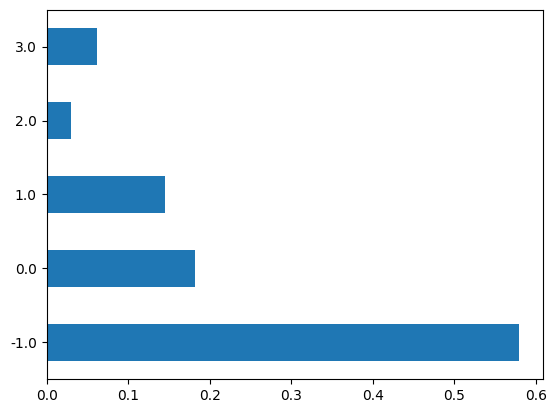

In [72]:
df_inspected["priority"].fillna(-1).value_counts(normalize = True).sort_index().plot.barh()

### Check cases with errors

In [22]:
df_inspected[(df_inspected["priority"].notnull() | df_inspected["cluster_priority"].notnull())]

,id,priority,cluster_priority,text,label,label_recommended,exact_incoherence_recommendation,approx_incoherence_recommendation,model_incoherence_recommendation,is_incoherent,is_exact_incoherence,is_approx_incoherence,is_model_incoherence,exact_incoherence_metadata,approx_incoherence_metadata,model_incoherence_metadata,cluster_incoherence_count,cluster_total_count
4567,559637,0.0,0.0,The MTCN code did not arrive. More than 50 day...,Request for information - Assistance timing or...,Request for information - Targeting criteria,Request for information - Targeting criteria,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,1,1,1,1,"{'exact_incoherence_cluster_index': 165.0, 'ex...","{'approx_incoherence_cluster_index': 0.0, 'app...",{'model_incoherence_severity': 0.6872487681548...,576.0,1393.0
6736,585890,0.0,0.0,The MTCN code did not arrive. Received an SMS ...,Request for information - Assistance duration,Request for information - Targeting criteria,Request for information - Targeting criteria,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,1,1,1,1,"{'exact_incoherence_cluster_index': 68.0, 'exa...","{'approx_incoherence_cluster_index': 0.0, 'app...",{'model_incoherence_severity': 0.9989767111168...,576.0,1393.0
8342,600348,0.0,0.0,The MTCN code did not arrive. Received an SMS ...,Request for information - Other (please explain),Request for information - Targeting criteria,Request for information - Targeting criteria,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,1,1,1,1,"{'exact_incoherence_cluster_index': 68.0, 'exa...","{'approx_incoherence_cluster_index': 0.0, 'app...",{'model_incoherence_severity': 0.9954472010089...,576.0,1393.0
4952,563819,1.0,0.0,The MTCN code did not arrive. More than 50 day...,Request for information - Other (please explain),Complaint - Assistance / Delivery Mechanisms /...,None,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,1,0,1,1,"{'exact_incoherence_cluster_index': nan, 'exac...","{'approx_incoherence_cluster_index': 0.0, 'app...",{'model_incoherence_severity': 0.9883657994091...,576.0,1393.0
6935,540414,1.0,0.0,The MTCN code did not arrive. More than 50 day...,Complaint - Incorrect records,Complaint - Assistance / Delivery Mechanisms /...,None,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,1,0,1,1,"{'exact_incoherence_cluster_index': nan, 'exac...","{'approx_incoherence_cluster_index': 0.0, 'app...",{'model_incoherence_severity': 0.9675125838860...,576.0,1393.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10222,496454,3.0,NaN,did not receive 3 help\nthe burned person's pa...,Complaint - Incorrect records,Complaint - Assistance / Delivery Mechanisms /...,None,None,Complaint - Assistance / Delivery Mechanisms /...,1,0,0,1,"{'exact_incoherence_cluster_index': nan, 'exac...","{'approx_incoherence_cluster_index': nan, 'app...",{'model_incoherence_severity': 0.8422582085989...,NaN,NaN
10245,530047,3.0,NaN,did not receive any payment due to the fact th...,Technical requests - Withdrawal of personally ...,Complaint - Assistance / Delivery Mechanisms /...,None,None,Complaint - Assistance / Delivery Mechanisms /...,1,0,0,1,"{'exact_incoherence_cluster_index': nan, 'exac...","{'approx_incoherence_cluster_index': nan, 'app...",{'model_incoherence_severity': 0.8987482142804...,NaN,NaN
10267,527001,3.0,NaN,"On the website, the status ""Your application h...",Technical requests - Withdrawal of personally ...,Complaint - Assistance / Delivery Mechanisms /...,None,None,Complaint - Assistance / Delivery Mechanisms /...,1,0,0,1,"{'exact_incoherence_cluster_index': nan, 'exac...","{'approx_incoherence_cluster_index': nan, 'app...",{'model_incoherence_severity': 0.7726238277221...,NaN,NaN
10287,535840,3.0,NaN,According to the instru

### Check transposed table for better visualization 

In [67]:
df_inspected[
    [
        "id", 
        "priority", "cluster_priority",
        "text", "label",
        "exact_incoherence_recommendation", 
        "approx_incoherence_recommendation", 
        "model_incoherence_recommendation", 
        "cluster_incoherence_count",
        "is_incoherent", 
        "is_exact_incoherence","is_approx_incoherence", "is_model_incoherence", 
        "exact_incoherence_metadata", "approx_incoherence_metadata","model_incoherence_metadata", ]
].T

,4567,6736,8342,4952,6935,9478,2765,2829,7582,10187,...,10317,10318,10320,10322,10323,10325,10326,10327,10328,10338
id,559637,585890,600348,563819,540414,514132,534995,522778,503722,554460,...,538556,537795,567952,567885,537750,561546,538519,552764,537334,545421
priority,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cluster_priority,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,The MTCN code did not arrive. More than 50 day...,The MTCN code did not arrive. Received an SMS ...,The MTCN code did not arrive. Received an SMS ...,The MTCN code did not arrive. More than 50 day...,The MTCN code did not arrive. More than 50 day...,The MTCN code did not arrive. More than 50 day...,The MTCN code did not arrive. More than 50 day...,The MTCN code did not arrive. More than 50 day...,The MTCN code did not arrive. More than 50 day...,The MTCN code did not arrive. More than 50 day...,...,According to case 269686\nCan't get to the ban...,Repeat request\nA person with reduced mobility...,"A person with limited mobility, a transfer of ...","The recipient of the aid was injured, cannot m...","A person with reduced mobility, does not have ...","Under number 380962139303, there is no informa...",According to case 179681\n\nThe person has pro...,A person with reduced mobility,a person with a disability cannot receive assi...,Changing the phone number\nMs. Lyubov lives in...
label,Request for information - Assistance timing or...,Request for information - Assistance duration,Request for information - Other (please explain),Request for information - Other (please explain),Complaint - Incorrect records,Complaint - Incorrect records,Complaint - Incorrect records,Complaint - Incorrect records,Complaint - Incorrect records,Complaint - Incorrect records,...,Complaint - Physical access challenges,Complaint - Physical access challenges,Complaint - Physical access challenges,Complaint - Physical access challenges,Complaint - Physical access challenges,Complaint - Incorrect records,Complaint - Physical access challenges,Complaint - Physical access challenges,Complaint - Physical access challenges,Complaint - Incorrect records
exact_incoherence_recommendation,Request for information - Targeting criteria,Request for information - Targeting criteria,Request for information - Targeting criteria,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
approx_incoherence_recommendation,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,...,None,None,None,None,None,None,None,None,None,None
model_incoherence_recommendation,None,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,Complaint - Assistance / Delivery Mechanisms /...,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
cluster_incoherence_count,576.0,576.0,576.0,576.0,576.0,576.0,576.0,576.0,576.0,576.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_incoherent,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


---

# Generate the report 

<i> Runs report pipeline: With the input of inspected dataset, create a well formatted excel file </i>
<br>
<br>
**ATTENTION: Don't forget Run the inspection pipeline first**

In [73]:
reporter = IncoherenceReporter(
    df = df_inspected,
    path = "/Users/erichsato/Documents/WFP/01_programming/nlp_cfm/data/temp/report_tests/report_v6.xlsx",
    text_col="text",
    label_col="label",
)
reporter.report()

---

---

---

# EXTRA: Drafts 

## Semantic ordering

<i> A semantic ordering implementation using Nearest Neighbor graphs (Instead of Hierarchical Agglomerative Clustering, which is too slow) </i>

In [559]:
nn_graph = inspector.detectors[1].nn_graph
coo_graph = nn_graph.tocoo()
non_zero_cond = (coo_graph.data > 0)

max_embedding_distance = inspector.detectors[1].max_embedding_distance
step = 0.005
sort_steps = np.arange(step, max_embedding_distance + step, step)

sort_matrix = np.zeros(shape = (nn_graph.shape[0],len(sort_steps)))
for index,sort_step in enumerate(sort_steps):
    
    # filter only connections that matter
    #   1. it has to be connected (non zero)
    #   2. it has to be sorted
    mask = non_zero_cond & (coo_graph.data <= sort_step)
    filtered_nn_graph = csr_matrix((coo_graph.data[mask], (coo_graph.row[mask], coo_graph.col[mask])), shape=nn_graph.shape)
    
    # calculate calculated components
    n_components, labels = connected_components(filtered_nn_graph)
    
    # sort and reindex, assign smaller indices for larger components
    #   1. create count dictionary
    #   2. reindex components according to size
    #   3. reassign components indices
    element_counts = dict(zip(*np.unique(labels, return_counts=True)))
    element_counts = dict(sorted(element_counts.items(), key = lambda item: item[1], reverse = True))
    index_map = {
        old_index:new_index
        for new_index, old_index in enumerate(element_counts.keys())
    }
    labels = np.array([index_map[old_index] for old_index in labels])
    
    # store indices in sort matrix
    sort_matrix[:,index] = labels

# create indices sorted by multiple columns, hierarchically. 
sorted_indices = np.lexsort(sort_matrix.T, axis = 0)

In [568]:
df_test.iloc[sorted_indices]

,id,text,label,is_exact_incoherence,exact_incoherence_recommendation,exact_incoherence_metadata,is_approx_incoherence,approx_incoherence_recommendation,approx_incoherence_metadata,is_model_incoherence,model_incoherence_recommendation,model_incoherence_metadata,priority
450,495778,The MTCN code did not arrive. More than 50 days since the last SMS with the code. MTCN resubmission required.\n,Complaint - Assistance / Delivery Mechanisms / Payment Instruments,0,None,"{'exact_incoherence_cluster_index': nan, 'exact_incoherence_cluster_size': nan, 'exact_incoherence_cluster_candidates': nan}",0,None,"{'approx_incoherence_cluster_index': 0.0, 'approx_incoherence_cluster_size': 1393.0, 'approx_incoherence_cluster_candidates': 576.0}",0,None,{'model_incoherence_severity': nan},NaN
524,497983,The MTCN code did not arrive. More than 50 days since the last SMS with the code. MTCN resubmission required.\n,Complaint - Assistance / Delivery Mechanisms / Payment Instruments,0,None,"{'exact_incoherence_cluster_index': nan, 'exact_incoherence_cluster_size': nan, 'exact_incoherence_cluster_candidates': nan}",0,None,"{'approx_incoherence_cluster_index': 0.0, 'approx_incoherence_cluster_size': 1393.0, 'approx_incoherence_cluster_candidates': 576.0}",0,None,{'model_incoherence_severity': nan},NaN
533,498099,The MTCN code did not arrive. More than 50 days since the last SMS with the code. MTCN resubmission required.\n,Complaint - Assistance / Delivery Mechanisms / Payment Instruments,0,None,"{'exact_incoherence_cluster_index': nan, 'exact_incoherence_cluster_size': nan, 'exact_incoherence_cluster_candidates': nan}",0,None,"{'approx_incoherence_cluster_index': 0.0, 'approx_incoherence_cluster_size': 1393.0, 'approx_incoherence_cluster_candidates': 576.0}",0,None,{'model_incoherence_severity': nan},NaN
662,502173,The MTCN code did not arrive. More than 50 days since the last SMS with the code. MTCN resubmission required.,Complaint - Assistance / Delivery Mechanisms / Payment Instruments,0,None,"{'exact_incoherence_cluster_index': nan, 'exact_incoherence_cluster_size': nan, 'exact_incoherence_cluster_candidates': nan}",0,None,"{'approx_incoherence_cluster_index': 0.0, 'approx_incoherence_cluster_size': 1393.0, 'approx_incoherence_cluster_candidates': 576.0}",0,None,{'model_incoherence_severity': nan},NaN
696,503377,The MTCN code did not arrive. More than 50 days since the last SMS with the code. MTCN resubmission required.,Complaint - Assistance / Delivery Mechanisms / Payment Instruments,0,None,"{'exact_incoherence_cluster_index': nan, 'exact_incoherence_cluster_size': nan, 'exact_incoherence_cluster_candidates': nan}",0,None,"{'approx_incoherence_cluster_index': 0.0, 'approx_incoherence_cluster_size': 1393.0, 'approx_incoherence_cluster_candidates': 576.0}",0,None,{'model_incoherence_severity': nan},NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10327,552764,A person with reduced mobility,Complaint - Physical access challenges,0,None,"{'exact_incoherence_cluster_index': nan, 'exact_incoherence_cluster_size': nan, 'exact_incoherence_cluster_candidates': nan}",0,None,"{'approx_incoherence_cluster_index': nan, 'approx_incoherence_cluster_size': nan, 'approx_incoherence_cluster_candidates': nan}",0,None,{'model_incoherence_severity': nan},NaN
10328,537334,a person with a disability cannot receive assistance,Complaint - Physical access challenges,0,None,"{'exact_incoherence_cluster_index': nan, 'exact_incoherence_cluster_size': nan, 'exact_incoherence_cluster_candidates': nan}",0,None,"{'approx_incoherence_cluster_index': nan, 'approx_incoherence_cluster_size': nan, 'approx_incoherence_cluster_candidates': nan}",0,None,{'model_incoherence_severity': nan},NaN
10329,538015,"Text of case number 229107\nUnable to receive transfer. Man is not walking. The card cannot be received - it is refused.\nPlease consider the issue and forward the MTSN code that arrived on November 17\nmade a bank card. received 1 payment. the code is expired for 2 previous